In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, metrics
import numpy as np
import os
import time

import imageio
import glob
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
#from tensorflow_docs.vis import embed
from sklearn.model_selection import train_test_split
#!pip install -q git+https://github.com/tensorflow/docs
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import imageio
from scipy.linalg import sqrtm
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.callbacks import Callback


# Initialize rng
rng = np.random.default_rng(2022)

auc = tf.keras.metrics.AUC()

In [8]:
batch_size = 32 # This is a tunable hyperparameter
shape = (128, 128) # note we are reducing the size of the image

data_dir = '/content/drive/MyDrive/Eye_Dataset/'

train_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'train_new'),
                                                       seed=rng.integers(500000),
                                                       image_size=shape,
                                                       label_mode="categorical",
                                                       color_mode='grayscale',
                                                       batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'validation/validation'),
                                                     seed=rng.integers(500000),
                                                     image_size=shape,
                                                     label_mode="categorical",
                                                     color_mode='grayscale',
                                                     batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test_new'),
                                                      seed=rng.integers(500000),
                                                      image_size=shape,
                                                      color_mode='grayscale',
                                                      batch_size=batch_size)

Found 16000 files belonging to 4 classes.
Found 4000 files belonging to 4 classes.
Found 4000 files belonging to 4 classes.


In [9]:
# Check shape of data
for x, y in train_ds.take(1):
  print(x.shape)
  print(y.shape)

(32, 128, 128, 1)
(32, 4)


In [10]:
 for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

Images batch shape: (32, 128, 128, 1)
Labels batch shape: (32, 4)


In [11]:
train_dir = '/content/drive/MyDrive/Eye_Dataset/train_new'

class_names_list = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
class_names_list

['DME', 'DRUSEN', 'NORMAL', 'CNV']

In [12]:
# Number of classes (4 in your case: 'CNV', 'DME', 'DRUSEN', 'NORMAL')
num_classes = len(class_names_list)
num_classes

4

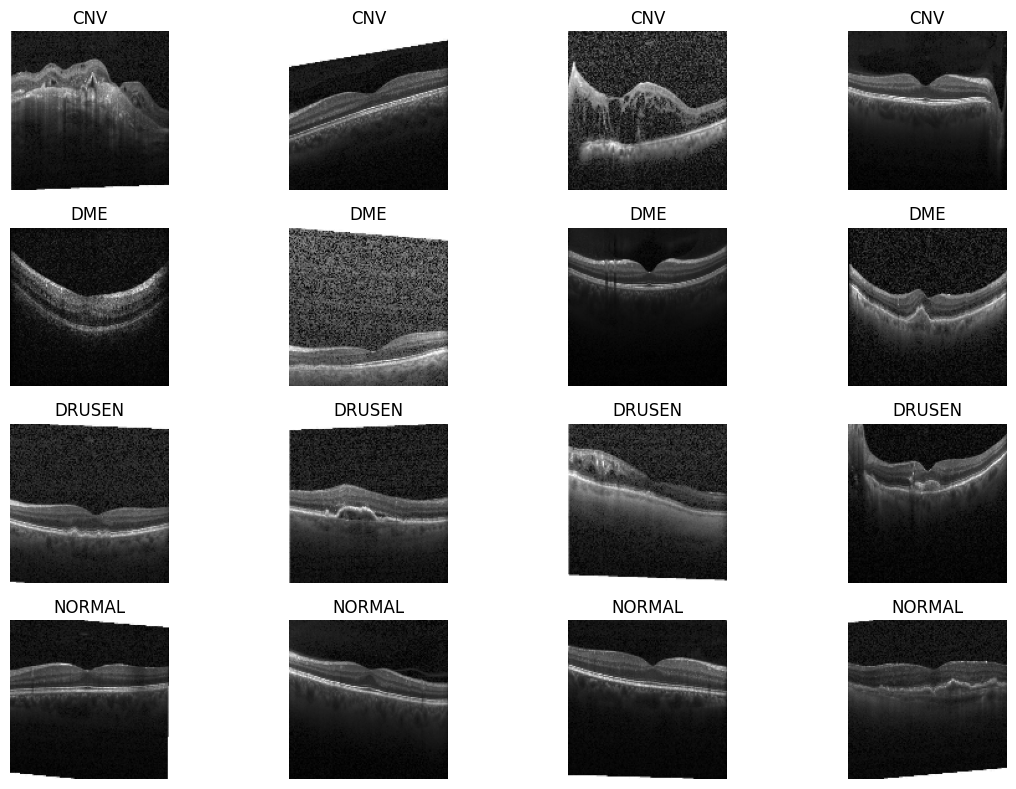

In [13]:
# Define a mapping from class index to class name
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Create a figure with 4 rows (one for each class)
plt.figure(figsize=(12, 8))

# Loop through each class
for class_idx, class_name in enumerate(class_names):
    # Find 4 example images from the class
    example_images = []
    for images, labels in train_ds:
        if tf.argmax(labels[0]) == class_idx:  # Check if the label matches the current class
            for i in range(4):  # Collect 4 example images
                example_images.append(images[i].numpy().squeeze())  # Assuming grayscale images
            break

    # Plot the example images in a row
    for i, example_image in enumerate(example_images):
        plt.subplot(4, len(class_names), i + 1 + class_idx * 4)
        plt.title(class_name)
        plt.imshow(example_image, cmap='gray')
        plt.axis('off')

plt.tight_layout()
plt.show()

Initialize Hyperparameter

In [14]:
buffer_size = 16000
batch_size = 64
num_channels = 1
num_classes = len(class_names_list)
image_size = 128
latent_dim = 100

In [15]:
# normalize image pixels into range [-1, 1]
def normalize(image, label):
  """
  The normalization function will transform each image pixel value to the range [-1, 1], while the labels remain unchanged.

  """
  image = (image - 127.5) / 127.5
  return image, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)
train_ds


<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [16]:
# Add class labels in one-hot encoding to the generator input and discriminator input
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

104 5


Create Generator / Discriminator

In [17]:
# Modified generator for grayscale images with 4 classification channels
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(8 * 8 * 512),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, 512)),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(4, (7, 7), padding="same", activation='softmax'),  # Output grayscale image with 4 classes
    ],
    name="generator",
)

# Improved generator
# Modified discriminator for grayscale images with 4 classification channels
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((128, 128, discriminator_in_channels)),  # Input shape includes classification channels
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(4, activation='softmax'),  # 4-class classification
    ],
    name="discriminator",
)


In [24]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3440640   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 512)         2048      
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       2097408   
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0 

In [25]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        2944      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                    

In [18]:
def preprocess_image(image, label, target_channels=1):
    """
    Convert the image to the target number of channels.
    - If target_channels is 3, convert to RGB.
    - If target_channels is 1, convert to grayscale.
    """
    image_channels = image.shape[-1]
    if target_channels == 3 and image_channels == 1:
        # Convert grayscale to RGB
        image = tf.image.grayscale_to_rgb(image)
    elif target_channels == 1 and image_channels == 3:
        # Convert RGB to grayscale
        image = tf.image.rgb_to_grayscale(image)
    return image, label

In [ ]:
# def preprocess_image(image, label, target_channels=1):
#     """
#     Convert the image to the target number of channels.
#     - If target_channels is 3, convert to RGB.
#     - If target_channels is 1, convert to grayscale.
#     """
#     image_channels = image.shape[-1]
#     if target_channels == 3 and image_channels == 1:
#         # Convert grayscale to RGB
#         image = tf.image.grayscale_to_rgb(image)
#     elif target_channels == 1 and image_channels == 3:
#         # Convert RGB to grayscale
#         image = tf.image.rgb_to_grayscale(image)
#     return image, label

# Apply the preprocessing function to the dataset
# target_channels = 1  # Set to 1 for grayscale
# train_ds_preproc = train_ds.map(lambda x, y: (preprocess_image(x, y, target_channels), y))
# train_ds_batch = train_ds_preproc.batch(batch_size)

# # Validation set
# val_ds_preproc = val_ds.map(lambda x, y: (preprocess_image(x, y, target_channels), y))
# val_ds_batch = val_ds_preproc.batch(batch_size)

# # Test set
# test_ds_preproc = test_ds.map(lambda x, y: (preprocess_image(x, y, target_channels), y))
# test_ds_batch = test_ds_preproc.batch(batch_size)


In [ ]:
# # Create the discriminator.
# discriminator = keras.Sequential(
#     [
#         keras.layers.InputLayer((128, 128, discriminator_in_channels)),
#         layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.GlobalMaxPooling2D(),
#         layers.Dense(1),
#     ],
#     name="discriminator",
# )

# # Create the generator.
# generator = keras.Sequential(
#     [
#         keras.layers.InputLayer((generator_in_channels,)),
#         layers.Dense(8 * 8 * 256),  # Start with an 8x8 feature map
#         layers.LeakyReLU(alpha=0.2),
#         layers.Reshape((8, 8, 256)),
#         layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),  # Upscale to 16x16
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),  # Upscale to 32x32
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),   # Upscale to 64x64
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same"),   # Upscale to 128x128
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),      # Produce final output
#     ],
#     name="generator",
# )

Conditional GAN

In [19]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        # Initialize additional metrics for multi-class classification
        self.accuracy_tracker = metrics.CategoricalAccuracy(name="accuracy")
        self.precision_tracker = metrics.Precision(name="precision")
        self.recall_tracker = metrics.Recall(name="recall")
        self.f1_score_tracker = metrics.Mean(name="f1_score")  # F1 is not built-in in Keras, so we need to handle it manually


    @property
    def metrics(self):
        return [
            self.gen_loss_tracker,
            self.disc_loss_tracker,
            self.accuracy_tracker,
            self.precision_tracker,
            self.recall_tracker,
            self.f1_score_tracker
        ]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn


    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Ensure one hot label is a two-dimensional tensor
        one_hot_labels = tf.reshape(one_hot_labels, [-1, 4])
        # Reshape or squeeze real_images if it has an extra dimension
        #print("Real images shape:", real_images.shape)
        #print("One-hot labels shape:", one_hot_labels.shape)

        real_images = tf.reshape(real_images, [-1, 128, 128, 1])


        #print("real image shapr after squeeze:", real_images.shape)
        # # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, None, None, :]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[128 * 128], axis=1)
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, 128, 128, 4))

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Concatenation
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)
        #print("Generated images shape:", generated_images.shape)
        #print("Image one hot labels shape:", image_one_hot_labels.shape)

        # Concatenate labels with fake and real images
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels[..., :1]], -1)

        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)

        # Check the shapes of both tensors
        #print("Fake image and labels shape:", fake_image_and_labels.shape)
        #print("Real image and labels shape:", real_image_and_labels.shape)

        fake_image_and_labels_adjusted = fake_image_and_labels[..., :5]  # Keep the first 5 channels
        real_image_and_labels_adjusted = real_image_and_labels[..., :5]  # Keep the first 5 channels
        #print("Fake image and labels shape:", fake_image_and_labels_adjusted.shape)
        #print("Real image and labels shape:", real_image_and_labels_adjusted.shape)

        # Concatenate the adjusted tensors
        combined_images = tf.concat([fake_image_and_labels_adjusted, real_image_and_labels_adjusted], axis=0)

        # Assemble labels discriminating real from fake images.
        labels_real = tf.ones((batch_size, 2))  # [1, 0] for real images
        labels_fake = tf.ones((batch_size, 2))  # [0, 1] for fake images
        labels = tf.concat([labels_real, labels_fake], axis=0)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels[:, 1], predictions[:, 1])
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Ensure the metrics are only updated with real images and labels
        # Update the metrics for real images and labels
        real_predictions = self.discriminator(real_image_and_labels, training=False)
        self.accuracy_tracker.update_state(one_hot_labels[:, 0], real_predictions[:, 0])  # Use one_hot_labels for accuracy
        self.precision_tracker.update_state(one_hot_labels[:, 0], real_predictions[:, 0])  # Use one_hot_labels for precision
        self.recall_tracker.update_state(one_hot_labels[:, 0], real_predictions[:, 0])  # Use one_hot_labels for recall

        # Calculate F1 score and update its tracker
        precision = self.precision_tracker.result()
        recall = self.recall_tracker.result()
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
        self.f1_score_tracker.update_state(f1_score)

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 4))  # 4 classes

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            #print("Fake images shape before concatenation:", fake_images.shape)
            #print("One-hot labels shape before concatenation:", image_one_hot_labels.shape)

            #fake_image_and_labels = tf.concat([fake_image_and_labels_adjusted, image_one_hot_labels], axis=-1)
            #fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], axis=-1)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels[..., :1]], axis=-1)
            #fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels[..., :3]], axis=-1)
            #fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels[..., :5]], axis=-1)
            #fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels[..., :4]], axis=-1)

            #print("Fake images shape after concatenation:", fake_image_and_labels.shape)
            #fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels[..., :1]], axis=-1)  # Concatenate along channel axis
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        # with tf.GradientTape() as tape:
        #     fake_images = self.generator(random_vector_labels)
        #     fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
        #     predictions = self.discriminator(fake_image_and_labels_adjusted)
        #     g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))


        # Collect the metric results
        metrics_results = {m.name: m.result() for m in self.metrics}


        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "accuracy": self.accuracy_tracker.result(),
            "precision": self.precision_tracker.result(),
            "recall": self.recall_tracker.result(),
        }


In [20]:
class F1ScoreCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        precision = self.model.precision_tracker.result().numpy()
        recall = self.model.recall_tracker.result().numpy()
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
        logs = logs or {}
        logs['f1_score'] = f1_score
        print(f'Epoch {epoch + 1}: F1-score is {f1_score}')


Conditional GAN model training

In [23]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.generator_losses = []
        self.discriminator_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.generator_losses.append(logs.get('g_loss'))
        self.discriminator_losses.append(logs.get('d_loss'))

class F1ScoreCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        precision = self.model.precision_tracker.result()
        recall = self.model.recall_tracker.result()
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
        logs['f1_score'] = f1_score
        print(f'Epoch {epoch + 1}: F1-score is {f1_score}')
        # Resetting the metrics is handled here
        for metric in self.model.metrics:
            metric.reset_states()

class MetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        # Log the metric values at the end of each epoch
        print(f"Epoch {epoch + 1}:")
        print(f"Generator Loss: {logs['g_loss']}")
        print(f"Discriminator Loss: {logs['d_loss']}")
        print(f"Accuracy: {logs['accuracy']}")
        print(f"Precision: {logs['precision']}")
        print(f"Recall: {logs['recall']}")
        print(f"F1 Score: {logs['f1_score']}")

# Create an instance of ConditionalGAN
cond_gan = ConditionalGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile the model
cond_gan.compile(
    d_optimizer=Adam(learning_rate=0.0003),
    g_optimizer=Adam(learning_rate=0.0003),
    loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),  # Use CategoricalCrossentropy
)

loss_history = LossHistory()
f1_callback = F1ScoreCallback()
metric_callback = MetricsCallback()  # Create an instance of MetricsCallback

history = cond_gan.fit(
    train_ds,
    epochs=2,
    callbacks=[loss_history, f1_callback, metric_callback]
)

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history.generator_losses, label='Generator Loss')
plt.plot(loss_history.discriminator_losses, label='Discriminator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

end_time = time.time()
total_time = (end_time - start_time) / 60
print(f"Training time: {total_time} mins")



Epoch 1/2
 45/500 [=>............................] - ETA: 57:56 - g_loss: 0.0000e+00 - d_loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: ignored

In [22]:
cond_gan.summary()

ValueError: ignored

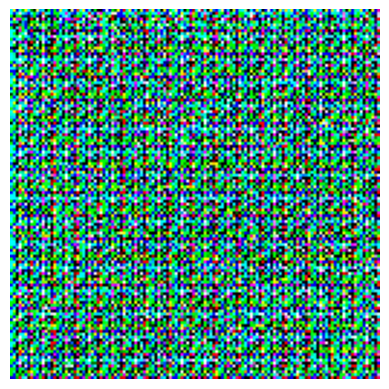

In [ ]:
class_labels = ['DME', 'DRUSEN', 'NORMAL', 'CNV']
class_to_one_hot = {class_label: [int(class_label == label) for label in class_labels] for class_label in class_labels}
# Define the size of the latent space
latent_dim = 100  # Adjust the dimensionality as needed

# Generate synthetic 'DME' image
batch_size = 32  # Specify the batch size
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))  # Replace latent_dim with your latent dimension
one_hot_dme = tf.one_hot([0] * batch_size, 4)  # Assuming 'DME' corresponds to class 0

# Concatenate random latent vectors and one-hot labels
random_vector_labels = tf.concat([random_latent_vectors, one_hot_dme], axis=1)

# Generate synthetic 'DME' image
generated_dme_image = cond_gan.generator(random_vector_labels)

# Convert the tensor to a NumPy array and squeeze it
generated_dme_image_np = generated_dme_image.numpy()[0]

# Plot the generated 'DME' image
plt.imshow(generated_dme_image_np, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:

# Define the class labels
class_labels = ['DME', 'DRUSEN', 'NORMAL', 'CNV']

# Create a figure to display the generated images
plt.figure(figsize=(12, 8))

# Loop through the class labels and generate an image for each class
for i, class_label in enumerate(class_labels):
    # Create a one-hot encoding for the current class
    one_hot_class = np.zeros(len(class_labels))
    one_hot_class[i] = 1

    # Generate a random latent vector
    random_latent_vector = np.random.normal(size=(1, latent_dim))

    # Concatenate the random latent vector and one-hot class label
    input_data = [random_latent_vector, one_hot_class]

    # Generate the image for the current class
    generated_image = cond_gan.generator.predict(input_data)

    # Convert the generated image to a NumPy array and select the first channel
    generated_image_np = generated_image[0]

    # Plot the generated image
    plt.subplot(1, len(class_labels), i + 1)
    plt.imshow(generated_image_np.squeeze(), cmap='gray')
    plt.title(class_label)
    plt.axis('off')

# Show the generated images
plt.show()

ValueError: ignored

<Figure size 1200x800 with 0 Axes>

In [ ]:
# # Measure training time
# start_time = time.time()
# print("start ", start_time)

# # Matrix to track
# additional_metrics = [
#     keras.metrics.BinaryAccuracy(name='accuracy'),

# ]

# cond_gan = ConditionalGAN(
#     discriminator=discriminator, generator=generator, latent_dim=latent_dim, additional_metrics=additional_metrics

# )
# cond_gan.compile(
#     d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
#     loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()],
# )

# cond_gan.fit(train_ds, epochs=20)

# end_time = time.time()
# total_time = (end_time - start_time)/60
# print(f"Training time: {total_time} mins")


start  1702070175.8340788
Epoch 1/20
Generated images shape: (None, 128, 128, 1)
Image one hot labels shape: (None, 128, 128, 4)
Generated images shape: (None, 128, 128, 1)
Image one hot labels shape: (None, 128, 128, 4)
500/500 [==============================] - 2956s 6s/step - g_loss: 4.5326 - d_loss: 0.0951
Epoch 2/20
500/500 [==============================] - 53s 106ms/step - g_loss: 8.6124 - d_loss: 1.7252e-04
Epoch 3/20
500/500 [==============================] - 53s 105ms/step - g_loss: 9.7226 - d_loss: 5.4424e-05
Epoch 4/20
500/500 [==============================] - 53s 106ms/step - g_loss: 10.4936 - d_loss: 2.5395e-05
Epoch 5/20
500/500 [==============================] - 57s 112ms/step - g_loss: 11.1017 - d_loss: 1.3844e-05
Epoch 6/20
500/500 [==============================] - 53s 105ms/step - g_loss: 11.5962 - d_loss: 8.4700e-06
Epoch 7/20
500/500 [==============================] - 53s 105ms/step - g_loss: 12.0340 - d_loss: 5.4917e-06
Epoch 8/20
500/500 [======================

Visualize Generated Images

In [ ]:
def calculate_accuracy(model, dataset):
    accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

    for images, labels in dataset:
        # Reshape the labels to match the image dimensions and concatenate
        image_one_hot_labels = labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[images.shape[1] * images.shape[2]]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, [-1, images.shape[1], images.shape[2], labels.shape[1]]
        )
        combined_input = tf.concat([images, image_one_hot_labels], axis=-1)

        # Predict labels using the model
        logits = model(combined_input, training=False)
        accuracy_metric.update_state(labels, logits)

    return accuracy_metric.result().numpy()


In [ ]:
train_accuracy = calculate_accuracy(cond_gan.discriminator, train_ds)
val_accuracy = calculate_accuracy(cond_gan.discriminator, val_ds)
#test_accuracy = calculate_accuracy(cond_gan.discriminator, test_ds)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
#print(f"Test Accuracy: {test_accuracy}")

KeyboardInterrupt: ignored

In [ ]:
def plot_generated_images(generator, num_examples=10, num_classes=4):
    # Generate noise for the generator
    noise = tf.random.normal([num_examples, latent_dim])

    # Generate random one-hot encoded labels
    random_labels = np.random.randint(0, num_classes, size=num_examples)
    one_hot_labels = tf.one_hot(random_labels, num_classes)

    # Concatenate noise and labels
    generator_input = tf.concat([noise, one_hot_labels], axis=1)

    # Generate images
    generated_images = generator(generator_input)

    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(5, 5, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

plot_generated_images(cond_gan.generator, num_examples=10, num_classes=4)

Plot Training Losses

Evaluate validation set

In [ ]:
def display_predictions(model, dataset):
    for images, labels in dataset.take(1):  # Take 1 batch from the dataset
        predictions = model(images, training=False)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        plt.figure(figsize=(10, 10))
        for i in range(25):  # Assuming the batch size is at least 25
            plt.subplot(5, 5, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i], cmap=plt.cm.binary)
            plt.xlabel(f"True: {true_classes[i]}, Pred: {predicted_classes[i]}")
        plt.show()

# Call the function with your model and dataset
display_predictions(cond_gan.discriminator, val_ds)

In [ ]:
test_accuracy = calculate_accuracy(cond_gan.discriminator, test_ds)

# print(f"Training Accuracy: {train_accuracy}")
# print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")